# **Classification Model and Evaluation**

## Objectives

* Answer business requirement 2:
    * The client is interested in using patient data to predict whether or not a patient is at risk of heart disease.
* Fit and evaluate a classification model to predict if a patient has heart disease or not.

## Inputs

* outputs/datasets/collection/HeartDiseasePrediction.csv
* Instructions on data cleaning and feature engineering from the relevant notebooks

## Outputs

* Data cleaning, feature engineering and modelling pipelines
* Feature importance plot


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/home/jfpaliga/CVD-predictor/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/home/jfpaliga/CVD-predictor'

# Load Data

Load the raw dataset and replace values of 0 in RestingBP and Cholesterol with NaN ready for the ML pipeline

In [4]:
import pandas as pd
import numpy as np

df = pd.read_csv("outputs/datasets/collection/HeartDiseasePrediction.csv")

for col in ["RestingBP", "Cholesterol"]:
    df[col] = df[col].replace(0, np.nan)

df.isna().sum()

Age                 0
Sex                 0
ChestPainType       0
RestingBP           1
Cholesterol       172
FastingBS           0
RestingECG          0
MaxHR               0
ExerciseAngina      0
Oldpeak             0
ST_Slope            0
HeartDisease        0
dtype: int64

---

# Classification ML Pipeline

## Pipeline for Data Cleaning and Feature Engineering

In [5]:
from sklearn.pipeline import Pipeline

#Data Cleaning
from feature_engine.imputation import MeanMedianImputer, RandomSampleImputer

# Feature Engineering
from feature_engine.discretisation import ArbitraryDiscretiser
from feature_engine.encoding import OrdinalEncoder


def DataCleaningandFeatEngPipeline():

    pipeline = Pipeline([
        ("median_imputation", MeanMedianImputer(imputation_method="median",
                                                variables=["RestingBP"])),
        ("random_sample_imputation", RandomSampleImputer(random_state=1,
                                                         seed='general',
                                                         variables=["Cholesterol"])),
        ("arbitrary_discretisation", ArbitraryDiscretiser(binning_dict={"Oldpeak":[-np.inf, 0, 1.5, np.inf]})),
        ("ordinal_encoding", OrdinalEncoder(encoding_method="arbitrary",
                                            variables=["Sex",
                                                       "ChestPainType",
                                                       "FastingBS",
                                                       "RestingECG",
                                                       "ExerciseAngina",
                                                       "ST_Slope"])),
        ])

    return pipeline

## Pipeline for Modelling

In [6]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

# Feature Selection
from sklearn.feature_selection import SelectFromModel

# ML Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from xgboost import XGBClassifier


def ClassificationPipeline(model):

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("feat_selection", SelectFromModel(model)),
        ("model", model),
        ])

    return pipeline

## Split Data into Train and Test Sets

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(["HeartDisease"], axis=1),
    df["HeartDisease"],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(734, 11) (734,) (184, 11) (184,)


### Check target distribution of train set

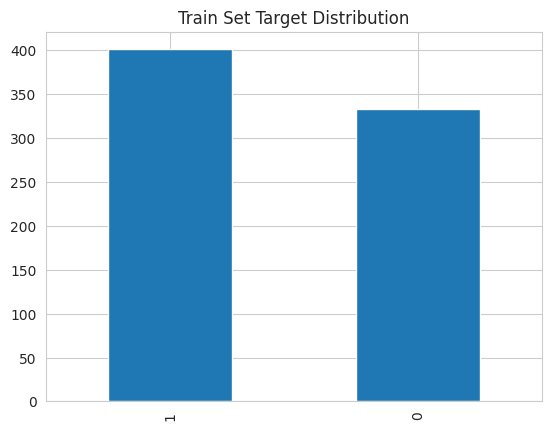

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

* The target looks relatively balanced, however in order to try and minimise overfitting oversampling will be performed.
* In order to do this, we first need to clean and encode the data.

In [9]:
data_cleaning_feat_eng_pipeline = DataCleaningandFeatEngPipeline()
X_train = data_cleaning_feat_eng_pipeline.fit_transform(X_train)
X_test = data_cleaning_feat_eng_pipeline.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(734, 11) (734,) (184, 11) (184,)


In [10]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(802, 11) (802,) (184, 11) (184,)


* Check target distribution **after** oversampling.

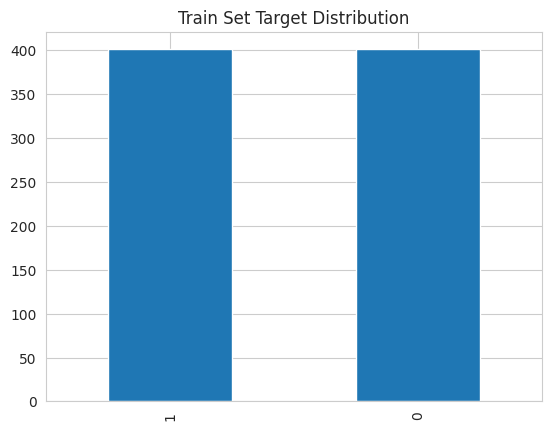

In [11]:
y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

## Hyperparameter Optimisation

* Load custom hyperparameter optimisation class from CodeInstitute

In [12]:
from sklearn.model_selection import GridSearchCV


class HyperparameterOptimizationSearch:

    def __init__(self, models, params):
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv, n_jobs, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print(f"\nRunning GridSearchCV for {key} \n")

            model = ClassificationPipeline(self.models[key])
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, )
            gs.fit(X, y)
            self.grid_searches[key] = gs

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                'estimator': key,
                'min_score': min(scores),
                'max_score': max(scores),
                'mean_score': np.mean(scores),
                'std_score': np.std(scores),
            }
            return pd.Series({**params, **d})

        rows = []
        for k in self.grid_searches:
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]
                scores.append(r.reshape(len(params), 1))

            all_scores = np.hstack(scores)
            for p, s in zip(params, all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)
        columns = ['estimator', 'min_score',
                   'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]
        return df[columns], self.grid_searches

### Finding the most suitable algorithm with HyperparameterOptimizationSearch

In [13]:
models_quick_search = {
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier": XGBClassifier(random_state=0),
    "DecisionTreeClassifier": DecisionTreeClassifier(random_state=0),
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "GradientBoostingClassifier": GradientBoostingClassifier(random_state=0),
    "ExtraTreesClassifier": ExtraTreesClassifier(random_state=0),
    "AdaBoostClassifier": AdaBoostClassifier(random_state=0),
}

params_quick_search = {
    "LogisticRegression": {},
    "XGBClassifier": {},
    "DecisionTreeClassifier": {},
    "RandomForestClassifier": {},
    "GradientBoostingClassifier": {},
    "ExtraTreesClassifier": {},
    "AdaBoostClassifier": {},
}

Using **default** hyperparameters to find best algorithm, scored by recall (as per business requirement 2)

In [14]:
from sklearn.metrics import make_scorer, recall_score

search = HyperparameterOptimizationSearch(models=models_quick_search, params=params_quick_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for DecisionTreeClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for GradientBoostingClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for ExtraTreesClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits

Running GridSearchCV for AdaBoostClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/home/jfpaliga/CVD-predictor/.venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/jfpaliga/CVD-predictor/.venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/jfpaliga/CVD-predictor/.venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/jfpaliga/CVD-predictor/.venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.

Results of GridSearch

In [15]:
grid_search_summary, grid_search_pipelines = search.score_summary(sort_by='mean_score')
grid_search_summary

,estimator,min_score,mean_score,max_score,std_score
3,RandomForestClassifier,0.753086,0.820617,0.8625,0.037284
0,LogisticRegression,0.7625,0.82034,0.864198,0.033605
1,XGBClassifier,0.7375,0.808056,0.8875,0.050026
4,GradientBoostingClassifier,0.7875,0.805463,0.825,0.015258
5,ExtraTreesClassifier,0.691358,0.785772,0.8625,0.05479
2,DecisionTreeClassifier,0.725,0.758148,0.8,0.029804
6,AdaBoostClassifier,0.6,0.680895,0.7875,0.066818


The top three algorithms rated by mean score for recall were RandomForestClassifier, LogisticRegression and XGBClassifier.

Using these three algorithms, extensive hyperparameter optimisation was carried out.

For further details on how hyperparameter ranges were selected, please see the Hyperparameter Optimisation notebook.

In [17]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
    "LogisticRegression": LogisticRegression(random_state=0),
    "XGBClassifier":XGBClassifier(random_state=0),
    
}

params_search = {
    "RandomForestClassifier": {
        "model__n_estimators": [50, 140, 300, 500],
        "model__max_depth": [None, 4, 15],
        "model__min_samples_split": [2, 5, 10, 15, 50],
        "model__min_samples_leaf": [1, 2, 5, 10, 50],
        "model__max_leaf_nodes": [None, 50],
        "model__max_features": [None, "sqrt", "log2"],
        },
    "LogisticRegression":{
        "model__penalty": ["l2", "l1", "elasticnet", None],
        "model__C": [10, 2, 1.0, 0.5, 0.1],
        "model__tol": [1e-3, 1e-4, 1e-5],
        },
    "XGBClassifier": {
        "model__n_estimators": [10, 30, 50, 100, 200],
        "model__max_depth": [None, 3, 15],
        "model__learning_rate": [0.001, 0.01, 0.1],
        "model__gamma": [0, 0.05, 0.075, 0.1],
        "model__min_child_weight": [1, 3, 5, 7],
        },
        }

Using more extensive hyperparameter options

In [18]:
search = HyperparameterOptimizationSearch(models=models_search, params=params_search)
search.fit(X_train, y_train,
           scoring =  make_scorer(recall_score, pos_label=1),
           n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits

Running GridSearchCV for LogisticRegression 

Fitting 5 folds for each of 60 candidates, totalling 300 fits


/home/jfpaliga/CVD-predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jfpaliga/CVD-predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jfpaliga/CVD-predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jfpaliga/CVD-predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jfpaliga/CVD-predictor/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/home/jfpaliga/


Running GridSearchCV for XGBClassifier 

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


Results of GridSearch

In [19]:
extensive_grid_search_summary, extensive_grid_search_pipelines = search.score_summary(sort_by='mean_score')
extensive_grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators,model__C,model__penalty,model__tol,model__gamma,model__learning_rate,model__min_child_weight
188,RandomForestClassifier,0.8375,0.902901,0.9875,0.057866,None,None,50,50,10,50,NaN,NaN,NaN,NaN,NaN,NaN
196,RandomForestClassifier,0.8375,0.902901,0.9875,0.057866,None,None,50,50,50,50,NaN,NaN,NaN,NaN,NaN,NaN
1396,RandomForestClassifier,0.8375,0.902901,0.9875,0.057866,15,None,50,50,50,50,NaN,NaN,NaN,NaN,NaN,NaN
796,RandomForestClassifier,0.8375,0.902901,0.9875,0.057866,4,None,50,50,50,50,NaN,NaN,NaN,NaN,NaN,NaN
688,RandomForestClassifier,0.8375,0.902901,0.9875,0.057866,4,None,None,50,10,50,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1852,LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,l1,0.0001,NaN,NaN,NaN
1853,LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,l1,0.00001,NaN,NaN,NaN
1854,LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,elasticnet,0.001,NaN,NaN,NaN
1855,LogisticRegression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.1,elasticnet,0.0001,NaN,NaN,NaN


Save the best model and parameters

In [20]:
best_model = extensive_grid_search_summary.iloc[0,0]
best_model

'RandomForestClassifier'

In [21]:
best_parameters = extensive_grid_search_pipelines[best_model].best_params_
best_parameters

{'model__max_depth': None,
 'model__max_features': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

Define the pipeline using the findings from hyperparameter optimisation

In [22]:
classification_pipeline = extensive_grid_search_pipelines[best_model].best_estimator_
classification_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('feat_selection',
                 SelectFromModel(estimator=RandomForestClassifier(random_state=0))),
                ('model',
                 RandomForestClassifier(max_features=None, min_samples_leaf=50,
                                        n_estimators=50, random_state=0))])

## Feature Importance

With the optimal pipeline found, the importance of features to the model can be assessed using the ```.feature_importances_``` attribute.

* We do this by assigning the features and their relative importance to a dataframe.
* We then use this dataframe to plot a bar plot.

* These are the 5 most important features in descending order.
* The model was trained using these features: ['ST_Slope', 'ChestPainType', 'MaxHR', 'Age', 'Cholesterol']


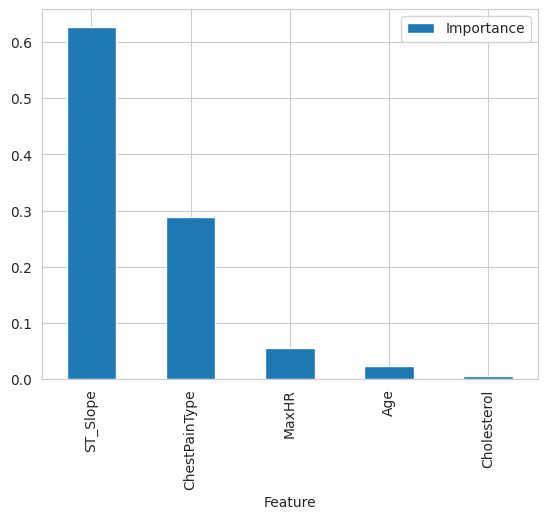

In [23]:
import matplotlib.pyplot as plt


classification_pipeline['feat_selection']

df_feature_importance = (pd.DataFrame(data={
    'Feature': X_train.columns[classification_pipeline['feat_selection'].get_support()],
    'Importance': classification_pipeline['model'].feature_importances_})
    .sort_values(by='Importance', ascending=False)
)

best_features = df_feature_importance["Feature"].to_list()

print(f"* These are the {len(best_features)} most important features in descending order.\n"
      f"* The model was trained using these features: {best_features}")

df_feature_importance.plot(kind="bar", x="Feature", y="Importance")
plt.show()

## Model Evaluation

In [24]:
from sklearn.metrics import classification_report, confusion_matrix


def confusion_matrix_and_report(X, y, pipeline, label_map):

    prediction = pipeline.predict(X)

    print('---  Confusion Matrix  ---')
    print(pd.DataFrame(confusion_matrix(y_true=prediction, y_pred=y),
          columns=[["Actual " + sub for sub in label_map]],
          index=[["Prediction " + sub for sub in label_map]]
          ))
    print("\n")

    print('---  Classification Report  ---')
    print(classification_report(y, prediction, target_names=label_map), "\n")


def clf_performance(X_train, y_train, X_test, y_test, pipeline, label_map):
    print("#### Train Set #### \n")
    confusion_matrix_and_report(X_train, y_train, pipeline, label_map)

    print("#### Test Set ####\n")
    confusion_matrix_and_report(X_test, y_test, pipeline, label_map)

In [25]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=classification_pipeline,
                label_map=["No Heart Disease", "Heart Disease"]
                )

#### Train Set #### 

---  Confusion Matrix  ---
                            Actual No Heart Disease Actual Heart Disease
Prediction No Heart Disease                     293                   46
Prediction Heart Disease                        108                  355


---  Classification Report  ---
                  precision    recall  f1-score   support

No Heart Disease       0.86      0.73      0.79       401
   Heart Disease       0.77      0.89      0.82       401

        accuracy                           0.81       802
       macro avg       0.82      0.81      0.81       802
    weighted avg       0.82      0.81      0.81       802
 

#### Test Set ####

---  Confusion Matrix  ---
                            Actual No Heart Disease Actual Heart Disease
Prediction No Heart Disease                      55                   13
Prediction Heart Disease                         22                   94


---  Classification Report  ---
                  precision    recall  f1-sco

Recall for heart disease was 89% on the train set and 88% on the test set and precision on no heart disease was 86% for the train set and 81% for the test set, passing the criteria set out in the ML business case.

## Refitting the ML Pipeline

We can refit the ML pipeline with the most important features to determine whether we get the same result as one fitted with all variables.

* The five most important features found from the model were "ST_Slope", "ChestPainType", "MaxHR", "Age" and "Cholesterol"

In [26]:
best_features

['ST_Slope', 'ChestPainType', 'MaxHR', 'Age', 'Cholesterol']

### Re-writing the ML Pipelines

We had two pipelines due to a target balancing step: one for data cleaning and feature engineering, and another for modelling

In [27]:
def DataCleaningandFeatEngPipeline():
    
    pipeline = Pipeline([
        ("random_sample_imputation", RandomSampleImputer(random_state=1,
                                                         seed='general',
                                                         variables=["Cholesterol"])),
        ("ordinal_encoding", OrdinalEncoder(encoding_method="arbitrary",
                                            variables=["ChestPainType",
                                                       "ST_Slope"])),
        ])

    return pipeline

def ClassificationPipeline(model):

    pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("model", model),
        ])

    return pipeline

### Split Train and Tests Sets Using Only Most Important Features

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(["HeartDisease"], axis=1),
    df["HeartDisease"],
    test_size=0.2,
    random_state=0,
)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(734, 11) (734,) (184, 11) (184,)


* Filter by most important features

In [29]:
X_train = X_train.filter(best_features)
X_test = X_test.filter(best_features)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
X_train.head(3)

(734, 5) (734,) (184, 5) (184,)


,ST_Slope,ChestPainType,MaxHR,Age,Cholesterol
378,Flat,ASY,157,70,NaN
356,Flat,ASY,113,46,NaN
738,Up,NAP,151,65,360.0


### Handle Target Imbalance

First, we pass the data through the data cleaning and feature engineering pipeline and assess the target distribution.

(734, 5) (734,) (184, 5) (184,)


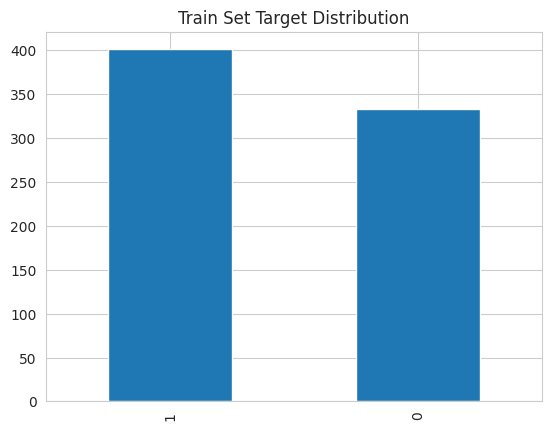

In [30]:
data_cleaning_feat_eng_pipeline = DataCleaningandFeatEngPipeline()
X_train = data_cleaning_feat_eng_pipeline.fit_transform(X_train)
X_test = data_cleaning_feat_eng_pipeline.transform(X_test)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

Then use SMOTE oversampling to rebalance the dataset.

(802, 5) (802,) (184, 5) (184,)


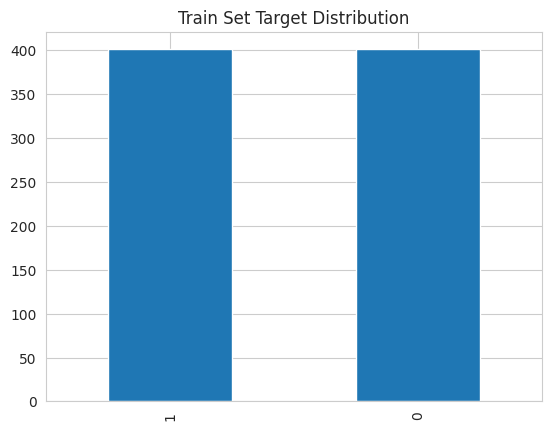

In [31]:
oversample = SMOTE(sampling_strategy='minority', random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

y_train.value_counts().plot(kind='bar', title='Train Set Target Distribution')
plt.show()

### Cross-Validation

We can then pass in the best model and hyperparameter values into the HyperparameterOptimisationSearch function to assess the new pipeline.

In [32]:
models_search = {
    "RandomForestClassifier": RandomForestClassifier(random_state=0),
}

In [33]:
best_parameters

{'model__max_depth': None,
 'model__max_features': None,
 'model__max_leaf_nodes': None,
 'model__min_samples_leaf': 50,
 'model__min_samples_split': 2,
 'model__n_estimators': 50}

Hyperparameter values need to be stored in a list before being passed into the function.

In [36]:
params_search = {'RandomForestClassifier': {
    'model__max_depth': [None],
    'model__max_features': [None],
    'model__max_leaf_nodes': [None],
    'model__min_samples_leaf': [50],
    'model__min_samples_split': [2],
    'model__n_estimators': [50]
    },
    }

In [37]:
quick_search = HyperparameterOptimizationSearch(
    models=models_search, params=params_search)
quick_search.fit(X_train, y_train,
                 scoring=make_scorer(recall_score, pos_label=1),
                 n_jobs=-1, cv=5)


Running GridSearchCV for RandomForestClassifier 

Fitting 5 folds for each of 1 candidates, totalling 5 fits


Checking the results

In [38]:
grid_search_summary, grid_search_pipelines = quick_search.score_summary(sort_by='mean_score')
grid_search_summary 

,estimator,min_score,mean_score,max_score,std_score,model__max_depth,model__max_features,model__max_leaf_nodes,model__min_samples_leaf,model__min_samples_split,model__n_estimators
0,RandomForestClassifier,0.875,0.935093,0.9875,0.039117,None,None,None,50,2,50


Defining the best classification pipeline

In [39]:
best_model = grid_search_summary.iloc[0, 0]
classification_pipeline = grid_search_pipelines[best_model].best_estimator_
classification_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_features=None, min_samples_leaf=50,
                                        n_estimators=50, random_state=0))])

### Evaluation of Pipeline on Train and Test Sets

As a reminder, the metrics defined in the ML business case were:
* 75% recall on Heart Disease
* 70% precision on No Heart Disease

In [40]:
clf_performance(X_train=X_train, y_train=y_train,
                X_test=X_test, y_test=y_test,
                pipeline=classification_pipeline,
                label_map=["No Heart Disease", "Heart Disease"]
                )

#### Train Set #### 

---  Confusion Matrix  ---
                            Actual No Heart Disease Actual Heart Disease
Prediction No Heart Disease                     295                   46
Prediction Heart Disease                        106                  355


---  Classification Report  ---
                  precision    recall  f1-score   support

No Heart Disease       0.87      0.74      0.80       401
   Heart Disease       0.77      0.89      0.82       401

        accuracy                           0.81       802
       macro avg       0.82      0.81      0.81       802
    weighted avg       0.82      0.81      0.81       802
 

#### Test Set ####

---  Confusion Matrix  ---
                            Actual No Heart Disease Actual Heart Disease
Prediction No Heart Disease                      55                   13
Prediction Heart Disease                         22                   94


---  Classification Report  ---
                  precision    recall  f1-sco

Using the two most important features, the recall on heart disease was 89% for the train set and 88% for the test set. The precision on no heart disease was 87% for the train set and 81% for the test set.

The metrics using these pipelines exceeds the criteria set out in the ML business case so we can use this pipeline moving forward.

---

# Push files to Repo

The following files will be generated:

* Train set
* Test set
* Data cleaning and feature engineering pipeline
* Modeling pipeline

In [42]:
import joblib
import os

version = "v2"
file_path = f"outputs/ml_pipeline/classification_model/{version}"

try:
  os.makedirs(name=file_path)
except Exception as e:
  print(e)


### Train Set

Save train set with variables already encoded (and after oversampling)

In [43]:
print(X_train.shape)
X_train.head(3)

(802, 5)


,ST_Slope,ChestPainType,MaxHR,Age,Cholesterol
0,0,0,157,70,190.0
1,0,0,113,46,219.0
2,1,1,151,65,360.0


In [44]:
X_train.to_csv(f"{file_path}/X_train.csv", index=False)

In [45]:
y_train

0      1
1      1
2      0
3      1
4      1
      ..
797    0
798    0
799    0
800    0
801    0
Name: HeartDisease, Length: 802, dtype: int64

In [46]:
y_train.to_csv(f"{file_path}/y_train.csv", index=False)

### Test Set

Save test set with variables already encoded

In [47]:
print(X_test.shape)
X_test.head(3)

(184, 5)


,ST_Slope,ChestPainType,MaxHR,Age,Cholesterol
306,0,0,155,55,190.0
711,0,0,151,66,302.0
298,0,0,92,51,219.0


In [48]:
X_test.to_csv(f"{file_path}/X_test.csv", index=False)

In [49]:
y_test

306    1
711    0
298    1
466    1
253    0
      ..
909    1
293    1
761    1
2      0
409    1
Name: HeartDisease, Length: 184, dtype: int64

In [50]:
y_test.to_csv(f"{file_path}/y_test.csv", index=False)

### ML Pipelines

Two pipelines will be saved: one for data cleaning and feature engineering, and another for modelling.

* When predicting Live Data, both pipelines will be required
* When predicting on the train and test sets, only the modelling pipeline is required as the data has already been processed

In [51]:
data_cleaning_feat_eng_pipeline

Pipeline(steps=[('random_sample_imputation',
                 RandomSampleImputer(random_state=1,
                                     variables=['Cholesterol'])),
                ('ordinal_encoding',
                 OrdinalEncoder(encoding_method='arbitrary',
                                variables=['ChestPainType', 'ST_Slope']))])

In [52]:
joblib.dump(value=data_cleaning_feat_eng_pipeline,
            filename=f"{file_path}/data_cleaning_and_feat_engineering_pipeline.pkl")

['outputs/ml_pipeline/classification_model/v2/data_cleaning_and_feat_engineering_pipeline.pkl']

In [53]:
classification_pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_features=None, min_samples_leaf=50,
                                        n_estimators=50, random_state=0))])

In [54]:
joblib.dump(value=classification_pipeline,
            filename=f"{file_path}/classification_pipeline.pkl")

['outputs/ml_pipeline/classification_model/v2/classification_pipeline.pkl']